<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [15]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.utils import lemmatize
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from spacy.lang.en import English
import pandas as pd

import pyLDAvis.gensim

pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

In [28]:
path = "./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"

In [29]:
df = pd.read_csv(path)

In [30]:
def tokenize(doc):
    return [token for token in simple_preprocess(doc) if token not in STOPWORDS]

In [31]:
df['tokens'] = df['reviews.text'].apply(tokenize)

In [32]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

In [33]:
df['tokens'][0]

['order',
 'item',
 'bad',
 'quality',
 'missing',
 'backup',
 'spring',
 'pcs',
 'aluminum',
 'battery',
 'work']

In [34]:
id2word = corpora.Dictionary(df['tokens'])

In [35]:
len(id2word.keys())

9622

In [36]:
id2word.filter_extremes(no_below=5, no_above=0.85)

In [37]:
len(id2word.keys())

3582

In [38]:
corpus = [id2word.doc2bow(text) for text in df['tokens']]

In [40]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

In [41]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [42]:
topics = [' '.join(t[0:5]) for t in words]

In [43]:
for id, t in enumerate(topics):
    print(f"###### Topic {id} Visual ######")
    print(t, end='\n')
    print("\n")

###### Topic 0 Visual ######
great tablet screen battery value


###### Topic 1 Visual ######
tablet amazon apps play use


###### Topic 2 Visual ######
kindle love screen new read


###### Topic 3 Visual ######
good price great far batteries


###### Topic 4 Visual ######
tablet price great games black


###### Topic 5 Visual ######
tablet year old bought works


###### Topic 6 Visual ######
batteries long great price work


###### Topic 7 Visual ######
christmas gift happy purchase bought


###### Topic 8 Visual ######
loves easy use old tablet


###### Topic 9 Visual ######
use books perfect love tablet


###### Topic 10 Visual ######
amazon like device use screen


###### Topic 11 Visual ######
batteries battery time charge work


###### Topic 12 Visual ######
love great good bought product


###### Topic 13 Visual ######
amazon batteries box thank best


###### Topic 14 Visual ######
great price kids product tablet




In [44]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-2.9026947301182577

In [45]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [46]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        start=2, 
                                                        limit=20, 
                                                        step=5,
                                                        passes=10)

In [47]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [48]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-2.535966,2,0
1,-2.619465,7,0
2,-2.760744,12,0
3,-2.760080,17,0
4,-2.582028,2,1


In [49]:
pyLDAvis.gensim.prepare(lda, corpus, id2word) # I have no clue where i got this code but !!!!I LOVE IT!!!!

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.238542 -0.054659       1        1  16.049572
8      0.198824  0.054237       2        1   9.789124
1      0.080586  0.035327       3        1   9.049054
2      0.014931  0.082423       4        1   8.809334
11    -0.208188  0.135002       5        1   6.844903
14     0.067702 -0.160789       6        1   5.833610
5      0.121955  0.010468       7        1   5.828429
9      0.150145  0.086734       8        1   5.821617
0      0.037065 -0.078970       9        1   5.644050
3     -0.086764 -0.195248      10        1   5.201946
12     0.088653 -0.043719      11        1   4.896180
10    -0.088052  0.099907      12        1   4.398690
13    -0.134489  0.032421      13        1   4.218193
4      0.048293 -0.003497      14        1   4.190378
7     -0.052118  0.000363      15        1   3.424923, topic_info=     Category         Freq         Term        Total  loglift  logprob
34    Default  5531.000000         good  5531.000000  30.0000  30.0000
18    Default  7483.000000    batteries  7483.000000  29.0000  29.0000
21    Default  8935.000000        great  8935.000000  28.0000  28.0000
17    Default  4905.000000        price  4905.000000  27.0000  27.0000
2076  Default  3000.000000       kindle  3000.000000  26.0000  26.0000
1857  Default  2098.000000        loves  2098.000000  25.0000  25.0000
2433  Default  6893.000000       tablet  6893.000000  24.0000  24.0000
192   Default  2547.000000         kids  2547.000000  23.0000  23.0000
521   Default  2085.000000          old  2085.000000  22.0000  22.0000
165   Default  2014.000000      product  2014.000000  21.0000  21.0000
24    Default  3871.000000       amazon  3871.000000  20.0000  20.0000
31    Default   965.000000    christmas   965.000000  19.0000  19.0000
105   Default  1759.000000         year  1759.000000  18.0000  18.0000
90    Default  3514.000000         love  3514.000000  17.0000  17.0000
755   Default  2849.000000         easy  2849.000000  16.0000  16.0000
885   Default  1126.000000         gift  1126.000000  15.0000  15.0000
2     Default  2086.000000      battery  2086.000000  14.0000  14.0000
20    Default  1264.000000        brand  1264.000000  13.0000  13.0000
652   Default  1721.000000        games  1721.000000  12.0000  12.0000
28    Default  3206.000000       bought  3206.000000  11.0000  11.0000
1679  Default  1612.000000       screen  1612.000000  10.0000  10.0000
23    Default  2416.000000         long  2416.000000   9.0000   9.0000
2087  Default  1512.000000        books  1512.000000   8.0000   8.0000
387   Default  1001.000000        value  1001.000000   7.0000   7.0000
432   Default   827.000000         deal   827.000000   6.0000   6.0000
7     Default  1305.000000      quality  1305.000000   5.0000   5.0000
74    Default   858.000000       brands   858.000000   4.0000   4.0000
94    Default  4373.000000          use  4373.000000   3.0000   3.0000
155   Default   473.000000          box   473.000000   2.0000   2.0000
728   Default   955.000000          son   955.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1160  Topic15    46.046925       opened    93.278809   2.6682  -5.4326
798   Topic15    80.175385      service   184.043030   2.5431  -4.8781
16    Topic15   262.629700        happy   855.854370   2.1927  -3.6916
633   Topic15   105.098160         sale   277.729004   2.4023  -4.6074
3     Topic15   132.357269         item   408.387268   2.2474  -4.3768
493   Topic15    25.489695     holidays    46.414810   2.7747  -6.0240
79    Topic15    67.069801        liked   168.610992   2.4522  -5.0566
40    Topic15   207.127136     purchase   960.632568   1.8398  -3.9290
1334  Topic15    27.373529        rough    55.593216   2.6656  -5.9527
414   Topic15   101.555527         sure   417.741638   1.9598  -4.6417
901   Topic15    88.525604        loved   413.752655   1.

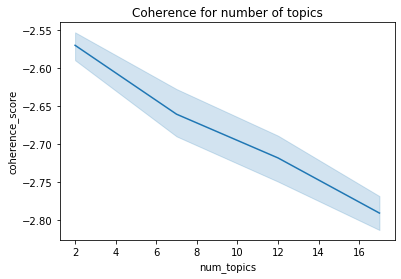

In [50]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)
ax.set_title("Coherence for number of topics");

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling